# DEMO: Hyperparameter Tuning via GridSearchCV

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.model_selection import GridSearchCV

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Create Snowpark Session

In [2]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [3]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


# Model Building

Parameter-Tuning is computationally expensive. So we will use a Snowpark-Optimized Warehouse for better performance.

In [4]:
session.use_warehouse('HOL_WH_HIGH_MEM')

In [5]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

In [6]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        'n_estimators':[10,50,100],
        'max_depth':[2,3,4]
        },
    n_jobs = -1,
    input_cols = feature_cols,
    label_cols = target_col,
    output_cols = 'PREDICTION',
    scoring="f1",
    )

grid_search.fit(train_sdf)

The version of package 'snowflake-snowpark-python' in the local environment is 1.9.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy==1.26.0'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'xgboost' in the local environment is 1.7.6, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


[14:28:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



## Analyze GridSearch Results

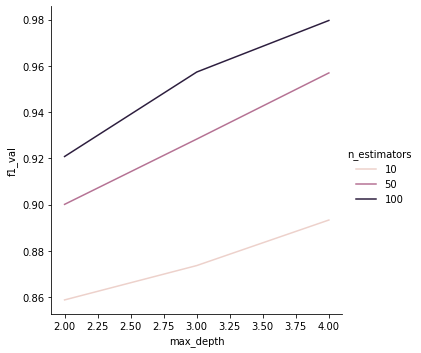

In [7]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
max_depth_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    max_depth_val.append(param_dict["max_depth"])

f1_val = gs_results["mean_test_score"]
gs_results_df = pd.DataFrame(data={"n_estimators":n_estimators_val,
                                   "max_depth":max_depth_val, 
                                   'f1_val':f1_val})
sns.relplot(data=gs_results_df, x="max_depth", y="f1_val", hue="n_estimators", kind='line')
plt.show()